# Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix, precision_score

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [3]:
data = pd.read_parquet('text_emotion_data.parquet').drop(
    [
        'ru_text',
        'id',
        'author',
        'subreddit',
        'link_id',
        'parent_id',
        'created_utc',
        'rater_id',
        'example_very_unclear',
        ],
        axis=1)

In [4]:
data

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
id_to_label = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral',
}

In [6]:
ru_emotions = {
    0: 'восхищение',
    1: 'веселье',
    2: 'злость',
    3: 'раздражение',
    4: 'одобрение',
    5: 'забота',
    6: 'непонимание',
    7: 'любопытство',
    8: 'желание',
    9: 'разочарование',
    10: 'неодобрение',
    11: 'отвращение',
    12: 'смущение',
    13: 'возбуждение',
    14: 'страх',
    15: 'признательность',
    16: 'горе',
    17: 'радость',
    18: 'любовь',
    19: 'нервозность',
    20: 'оптимизм',
    21: 'гордость',
    22: 'осознание',
    23: 'облегчение',
    24: 'раскаяние',
    25: 'грусть',
    26: 'удивление',
    27: 'нейтральность',
    }

In [7]:
translate_emotion = {id_to_label[i]: ru_emotions[i] for i in range(len(id_to_label))}

In [8]:
translate_emotion

{'admiration': 'восхищение',
 'amusement': 'веселье',
 'anger': 'злость',
 'annoyance': 'раздражение',
 'approval': 'одобрение',
 'caring': 'забота',
 'confusion': 'непонимание',
 'curiosity': 'любопытство',
 'desire': 'желание',
 'disappointment': 'разочарование',
 'disapproval': 'неодобрение',
 'disgust': 'отвращение',
 'embarrassment': 'смущение',
 'excitement': 'возбуждение',
 'fear': 'страх',
 'gratitude': 'признательность',
 'grief': 'горе',
 'joy': 'радость',
 'love': 'любовь',
 'nervousness': 'нервозность',
 'optimism': 'оптимизм',
 'pride': 'гордость',
 'realization': 'осознание',
 'relief': 'облегчение',
 'remorse': 'раскаяние',
 'sadness': 'грусть',
 'surprise': 'удивление',
 'neutral': 'нейтральность'}

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [9]:
backbone = transformers.TFAutoModel.from_pretrained('./bart-base')

All PyTorch model weights were used when initializing TFBartModel.

All the weights of TFBartModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartModel for predictions without further training.


Load tokenizer to be used with the model

In [10]:
tokenizer = transformers.AutoTokenizer.from_pretrained('facebook/bart-base')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [ ]:
tokenize_seq = []

for text in tqdm.tqdm(data['text']):
    tokenize_seq.append(tokenizer(text))

with open('tokenize_seq', 'wb') as file:
    pickle.dump(tokenize_seq, file)

In [11]:
with open('tokenize_seq', 'rb') as file:
    tokenize_seq = pickle.load(file)

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences([i['input_ids'] for i in tokenize_seq], maxlen=128, truncating='post', padding='post', value=tokenizer.pad_token_id)

In [13]:
y = data[data.columns.difference(['text'])].values

In [14]:
text_dataset = tf.data.Dataset.from_tensor_slices(X).batch(64)

In [ ]:
features = []

for data in tqdm.tqdm(text_dataset):
    features.extend(tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1))

features = np.array(features)
np.save('features.npy', features)

In [15]:
features = np.load('features.npy')

In [16]:
features, features.shape

(array([[ 1.9268482 , -1.8083783 ,  1.1634356 , ..., -0.25005838,
          1.684664  ,  0.59326035],
        [ 1.2231605 , -1.1030577 , -0.28428376, ...,  1.1343532 ,
          1.3022391 ,  0.54750144],
        [ 1.9432738 , -1.8364208 ,  0.81785935, ...,  0.1901779 ,
          0.8832531 ,  0.98668087],
        ...,
        [ 2.0871496 , -1.9621882 ,  0.7568142 , ..., -0.07704715,
          1.2768964 ,  0.62696475],
        [ 1.5172942 , -1.0947775 , -0.6264874 , ...,  0.84136087,
          1.7282301 ,  1.0637035 ],
        [ 1.5030369 , -0.8643758 , -0.8128365 , ...,  1.1897686 ,
          1.5710945 ,  0.9328568 ]], dtype=float32),
 (211225, 768))

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [17]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y)

In [18]:
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [19]:
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(256)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(256)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [20]:
inputs = tf.keras.layers.Input(768, name='input', dtype=tf.float32)
x = tf.keras.layers.Dense(512, name='dense-1', activation='relu')(inputs)
x = tf.keras.layers.Dense(256, name='dense-2', activation='relu')(x)
x = tf.keras.layers.Dense(len(translate_emotion), name='presiction', activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='minecraft')

Compile the model. Choose loss and metrics.

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[tf.keras.metrics.Precision()])

# Train the model

In [22]:
model.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
619/619 [==============================] - 7s 10ms/step - loss: 0.1496 - precision: 0.4026 - val_loss: 0.1401 - val_precision: 0.6668
Epoch 2/5
619/619 [==============================] - 5s 7ms/step - loss: 0.1375 - precision: 0.6244 - val_loss: 0.1366 - val_precision: 0.6645
Epoch 3/5
619/619 [==============================] - 4s 7ms/step - loss: 0.1340 - precision: 0.6371 - val_loss: 0.1346 - val_precision: 0.7077
Epoch 4/5
619/619 [==============================] - 4s 7ms/step - loss: 0.1319 - precision: 0.6441 - val_loss: 0.1333 - val_precision: 0.7321
Epoch 5/5
619/619 [==============================] - 5s 7ms/step - loss: 0.1306 - precision: 0.6455 - val_loss: 0.1324 - val_precision: 0.7131


# Evaluation

Evalute the model on test data.

In [23]:
model.evaluate(X_test, y_test, batch_size=128)

413/413 [==============================] - 3s 6ms/step - loss: 0.1324 - precision: 0.7131


[0.1324434131383896, 0.7131015062332153]

Plot confusion matrix.

1651/1651 [==============================] - 4s 2ms/step


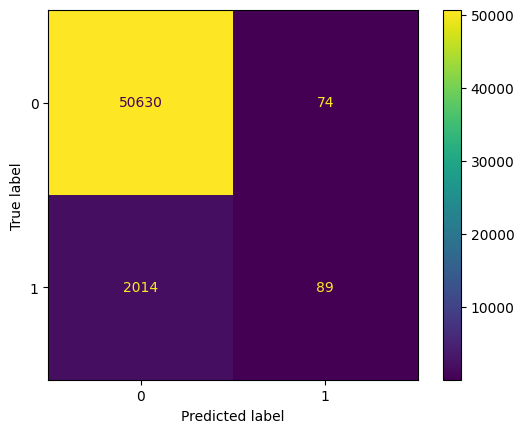

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test[:, 2], np.where(model.predict(X_test)[:, 2] >= 0.37, 1, 0))

In [25]:
predict = model.predict(X_test)
best_threshold = 0

for threshold in np.arange(0, 1, 0.01):
    y_pred = np.where(predict >= threshold, 1, 0)
    score = precision_score(y_test, y_pred, average='macro', zero_division=0)

    if score > best_threshold:
        best_threshold = score

best_threshold

1651/1651 [==============================] - 3s 2ms/step


0.3919503873707488

Write a function to classify a piece of text.

In [26]:
def classify_text(text: str) -> tuple[list[int], np.ndarray]:
    data = tokenizer(text)
    data = tf.keras.preprocessing.sequence.pad_sequences([data['input_ids']], maxlen=128, truncating='post', padding='post', value=tokenizer.pad_token_id)
    features = tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1)
    predict = model.predict(features)
    classes = np.where(predict >= best_threshold, 1, 0)[0]
    return [id[0] for id in np.where(classes == 1) if id], predict

In [27]:
def convert_label2text(data: tuple[list[int], np.ndarray]) -> list[str]:
    return [id_to_label[id] for id in data[0] if data[0]]

In [28]:
classify_text('some text...')

1/1 [==============================] - 0s 18ms/step


C:\Users\dmitry\AppData\Local\Temp\ipykernel_14396\4117035192.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  return [id[0] for id in np.where(classes == 1) if id], predict


([],
 array([[0.07956127, 0.00627405, 0.02178998, 0.04230726, 0.10587922,
         0.02834583, 0.00492932, 0.00323248, 0.00790515, 0.02205418,
         0.03054773, 0.00475839, 0.00582497, 0.01508575, 0.01340399,
         0.00599222, 0.00104086, 0.01844314, 0.00058763, 0.00346053,
         0.33310685, 0.02446808, 0.00344593, 0.01489731, 0.00659389,
         0.00350331, 0.02138428, 0.00707013]], dtype=float32))

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [29]:
convert_label2text(classify_text('i love my life'))

1/1 [==============================] - 0s 18ms/step


['love']